<a href="https://colab.research.google.com/github/inessa3/DMML2020_Tesla/blob/main/2_First_Basic_cleaning_of_training_data%2BLR_with_TFIDF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://upload.wikimedia.org/wikipedia/commons/7/77/Logo_HEC_Lausanne.png' width="200">

# Explanation
This is the second notebook of our project. It deals with data cleaning as well as our first predictions. As we moved along, we made more iterations on data cleaning and predictions. To make our initial results replicable and to not overload single notebooks, we present each iteration in a single notebook. These are "3 Additional cleaning", "4 Improving LR with TFIDF+Other classifier + conclusion".

**Data cleaning**

In this notebook, we cleaned the training data. 

The goal of data cleaning is to improve its quality and to alleviate the predicting power of the data. It is the correction of inaccurate parts in the data and the removal of unnecessary parts which weakens the accuracy. To do so, the data has to be brought into a "clean" form which allows the classifier to recognize the patterns in the data.
A good example to understand data cleaning is the punctuation that does not give any predicting power. So it can be removed.

To clean the data, we did the following:
* Removal of duplicate tweets
* Removal of stopwords
* Removal of punctuation marks
* Lemmatization

**Test-train split**

A train/test split is necessary to verify how good one's predictions are. The data is split into two parts, one part goes into the training set, the remaining part goes into the test set.

For the test split, we did the following:
* Train/test split 80%-20% for the official training set, so that we could test the accuracy of our own predictions before submitting them.

**Prediction** 

At the end of this notebook, we did our first predictions. 

We tried several approaches (scores):
* Simple logistic regression (0.803)
* Best parameter with cross validation (below 0.803)
* Random forest (below 0.803)
* Best parameter without cross validation (**0.811**)

**Outlook**

Having done some initial data cleaning and some first regressions, we next tried to improve the model with additional data cleaning and other classifiers.

These subsequent iterations can be seen in the following notebooks ("3 Additional cleaning", "4 Improving LR with TFIDF+Other classifiers+ conclusion").

##Import Libraries

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
import seaborn as sns
sns.set_style("white")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Download Data

In [ ]:
# Training Data
df = pd.read_csv("https://raw.githubusercontent.com/inessa3/DMML2020_Tesla/main/data/training_data.csv")
df.head()

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [ ]:
# Test Data
df_test_data = pd.read_csv("https://raw.githubusercontent.com/inessa3/DMML2020_Tesla/main/data/test_data.csv")
df_test_data.head()

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball


#1.Cleaning the Training Dataset
To clean the dataset we use the SpaCy library and language model.

##1.1.Remove Duplicates
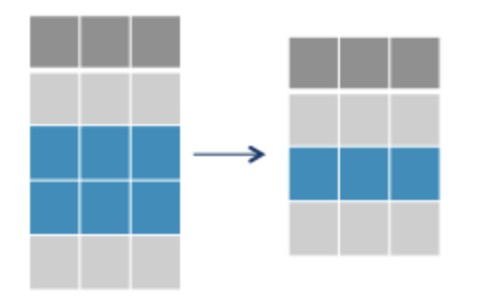

Here, we remove tweets that appeared twice or more in the dataset. Any redundant tweets do not add to the predictive power, so they can be removed.

Image source: https://www.datanovia.com/en/lessons/identify-and-remove-duplicate-data-in-r/

In [ ]:
df_duplicated_free=df.drop_duplicates(subset='text', keep='first')
df_duplicated_free

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


##1.2.Tokenize, Remove Stopwords and Punctuation Marks

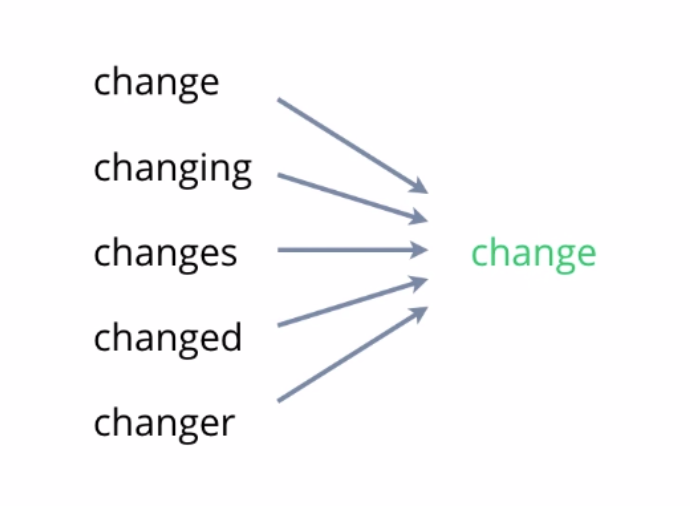

Here, we define a tokenizer function that lemmatizes the words, i.e. reduced the words to the stem. 
The function also removes stopwords and punctuations.

Image source: https://medium.com/swlh/introduction-to-stemming-vs-lemmatization-nlp-8c69eb43ecfe

In [ ]:
# Load English language model from SpaCy
sp = spacy.load('en_core_web_sm')

In [ ]:
# Import stopwords from English language
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Print total number of stopwords
print('Number of stopwords: %d' % len(stop_words))

Number of stopwords: 326


In [ ]:
# Create a list of punctuation marks
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

# Example
example = df_duplicated_free["text"].sample()
example.values[0]

'World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/BzdfznKvoG http://t.co/eRhdH37rDh'

In [ ]:
spacy_tokenizer(example.values[0])

['world',
 'war',
 'ii',
 'book',
 'lightning',
 'joe',
 'autobiography',
 'general',
 'j.',
 'lawton',
 'collins',
 'http://t.co/bzdfznkvog',
 'http://t.co/erhdh37rdh']

#2.Test-train Split
Now, we split data into a training set and a test set.

In [ ]:
# Select features
X = df_duplicated_free['text']
y = df_duplicated_free['target'] 

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

X_train

2378    Various issues fail to derail homes bid http:/...
5581    Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...
5162    @FedPorn I feel your pain. Survivors will look...
6009    Ron &amp; Fez - Dave's High School Crush https...
1548    || So.... I just watched the trailed for The D...
                              ...                        
2915    .@DinosaurDracula Felt remorse for missing Pam...
3995    @lordRsBiscuits That's always good for a prett...
5236    1 hour parade like 50 people collapsed. #OneHe...
5984    Christian Attacked by Muslims at the Temple Mo...
4631    Catching up on GBBO and omg that girls cake th...
Name: text, Length: 5109, dtype: object

In [ ]:
y_train

2378    0
5581    1
5162    1
6009    1
1548    0
       ..
2915    0
3995    1
5236    1
5984    1
4631    0
Name: target, Length: 5109, dtype: int64

#3.Prediction
This part of notebook is dedicated to predictions made using unlabelled test data. We made 4 attempts to predict the "target y" and submit these csv files on AIcrowd. In every attempt we changed some parameters. For example,  tuned the parameters of the vectorizer or classifier.

##1st Prediction: Simple logistic regression

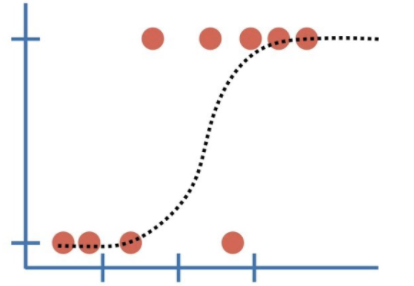

Here, we made our first prediction with the above defined model. We use a logistic regression without cross-validation and a vectorizer with pre-defined parameters.

Image source: https://www.youtube.com/watch?v=yIYKR4sgzI8

In [ ]:
#We use the above defined tokenizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Define classifier
classifier = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

In [ ]:
# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7f45d7458950>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
# Evaluate the model
def evaluate(true, pred):
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")

In [ ]:
# Evaluation - test set
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[670  92]
 [153 363]]
ACCURACY SCORE:
0.8083


###1.Submission **0.803**

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
y_totest = df_test_data['text']
y_totest

0       Crptotech tsunami and banks.\n http://t.co/KHz...
1       I'm that traumatised that I can't even spell p...
2       @foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3       Me watching Law &amp; Order (IB: @sauldale305)...
4                       Papi absolutely crushed that ball
                              ...                        
1137    @ItsQueenBaby I'm at work it's a bunch of ppl ...
1138    #?? #?? #??? #??? Suicide bomber kills 15 in S...
1139    Eruption of Indonesian volcano sparks transpor...
1140    Never let fear get in the way of achieving you...
1141    wowo--=== 12000 Nigerian refugees repatriated ...
Name: text, Length: 1142, dtype: object

In [ ]:
y_1 = pd.DataFrame()
y_1['target'] = pipe.predict(y_totest)
y_1

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
y_1.to_csv('y_1.csv')
!cp y_1.csv "drive/My Drive/DM&ML/Colab Notebooks/Project"

##2nd Prediction: Best parameter with cross validation **<0.803**

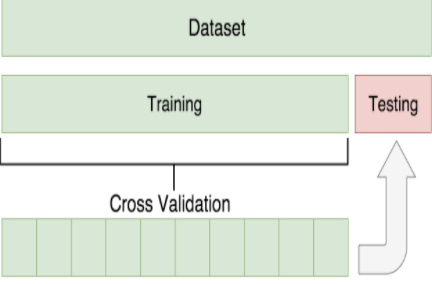

Here, we tried to find the best parameters for the vectorizer with cross validation. 
To do so, we defined a list of configurations, for each of which we ran the prediction. From there, we could read out the best parameters

We ended up with:
*   ngram range (1,1)
*   min_df = 1
*   max_df = 1.0
*   analyzer = 'word'

Finally, we used those parameters to run the prediction again. Unfortunately, our prediction did not improve. It was below the 0.803 that we achieved in the first prediction. So we did not submit it.

Image source: https://medium.com/@rj322198/cross-validation-in-machine-learning-c677653ea475

In [ ]:
#optimizing the parameters of the TfidfVectorizer class.
 # Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1), (1,2), (1, 3), (2, 2), (2, 3), (3, 3)]
    min_df = [1]
    max_df = [1.0]
    analyzer=['word', 'char']
    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                    cfg = [n, i, j, a]
                    models.append(cfg)
    return models

configs = configs()
configs[:10]

[[(1, 1), 1, 1.0, 'word'],
 [(1, 1), 1, 1.0, 'char'],
 [(1, 2), 1, 1.0, 'word'],
 [(1, 2), 1, 1.0, 'char'],
 [(1, 3), 1, 1.0, 'word'],
 [(1, 3), 1, 1.0, 'char'],
 [(2, 2), 1, 1.0, 'word'],
 [(2, 2), 1, 1.0, 'char'],
 [(2, 3), 1, 1.0, 'word'],
 [(2, 3), 1, 1.0, 'char']]

In [ ]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    classifier = LogisticRegressionCV(solver="lbfgs", max_iter=5000, random_state=72)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
 
    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
CONFUSION MATRIX:
[[639 123]
 [146 370]]
ACCURACY SCORE:
0.7895
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
CONFUSION MATRIX:
[[584 178]
 [211 305]]
ACCURACY SCORE:
0.6956
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[614 148]
 [137 379]]
ACCURACY SCORE:
0.7770
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[623 139]
 [167 349]]
ACCURACY SCORE:
0.7606
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
CONFUSION MATRIX:
[[607 155]
 [138 378]]
ACCURACY SCORE:
0.7707
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'char']
CONFUSION MATRIX:
[[632 130]
 [154 362]]
ACCURACY SCORE:
0.7778
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[668  94]
 [233 283]]
ACCURACY SCORE:
0.7441
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[641 121]
 [194 322]]
ACCURACY SCORE:
0.7535
-----------------------
CONFIG:  [(2, 3), 1, 1.0

In [ ]:
# Define vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1, 1),
                                   min_df= 1, max_df=1.0, analyzer= 'word') # we use the above defined tokenizer

# Define classifier
classifier = LogisticRegressionCV(solver="lbfgs", max_iter=5000, random_state=72)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

# Evaluation - training set
evaluate(y_train,pipe.predict(X_train))

CONFUSION MATRIX:
[[639 123]
 [146 370]]
ACCURACY SCORE:
0.7895
CONFUSION MATRIX:
[[2866   48]
 [ 219 1976]]
ACCURACY SCORE:
0.9477


### Not submitted
So, we managed to find out the best parameters and we are going to use them now:

In [ ]:
y_2 = df_test_data['text']
y_2

0       Crptotech tsunami and banks.\n http://t.co/KHz...
1       I'm that traumatised that I can't even spell p...
2       @foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3       Me watching Law &amp; Order (IB: @sauldale305)...
4                       Papi absolutely crushed that ball
                              ...                        
1137    @ItsQueenBaby I'm at work it's a bunch of ppl ...
1138    #?? #?? #??? #??? Suicide bomber kills 15 in S...
1139    Eruption of Indonesian volcano sparks transpor...
1140    Never let fear get in the way of achieving you...
1141    wowo--=== 12000 Nigerian refugees repatriated ...
Name: text, Length: 1142, dtype: object

In [ ]:
y_2 = pd.DataFrame()
y_2['target'] = pipe.predict(y_totest)
y_2

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
y_2.to_csv('y_2.csv')
!cp y_2.csv "drive/My Drive/DM&ML/Colab Notebooks/Project"

##3rd Prediction: Random Forest **<0.803**

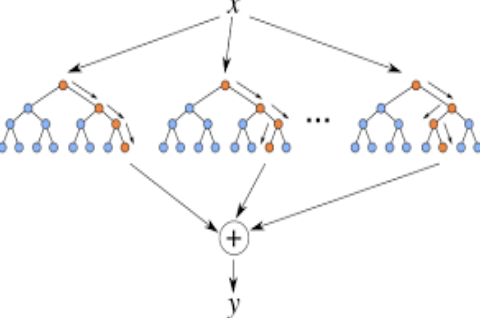

As a next attempt, we used the random forest classifier for the prediction. 
Such a classifier constructs decision trees, along which the prediction can follow. Even though it is a more complicated method, it did not improve our results. The score was still below our first prediction, so we did not submit it.

Image source: https://levelup.gitconnected.com/random-forest-regression-209c0f354c84

In [ ]:
#Use random forest
from sklearn.ensemble import RandomForestClassifier

# Define vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

# Define classifier
classifier = RandomForestClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

# Evaluation - training set
evaluate(y_train, pipe.predict(X_train))

CONFUSION MATRIX:
[[677  85]
 [175 341]]
ACCURACY SCORE:
0.7966
CONFUSION MATRIX:
[[2914    0]
 [   3 2192]]
ACCURACY SCORE:
0.9994


### Not submitted

In [ ]:
y_3 = df_test_data['text']
y_3 = pd.DataFrame()
y_3['target'] = pipe.predict(y_totest)
y_3

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
y_3.to_csv('y_3.csv')
!cp y_3.csv "drive/My Drive/DM&ML/Colab Notebooks/Project"

##4th Prediction: Best parameter without cross validation
Having learnt from our second prediction, we next tried to find the best parameter for the vectorizer without cross-validation

We ended up with the following parameters:
*   ngram range (1,2)
*   min_df = 1
*   max_df = 1.0
*   analyzer = 'word'

We then predited and evaluated again using these parameters.
This finally improved the prediction! We achieved a score of 0.811.

**The score obtained is the best we have so far**.

In [ ]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    classifier = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
 
    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
CONFUSION MATRIX:
[[670  92]
 [153 363]]
ACCURACY SCORE:
0.8083
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
CONFUSION MATRIX:
[[590 172]
 [220 296]]
ACCURACY SCORE:
0.6933
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[671  91]
 [152 364]]
ACCURACY SCORE:
0.8099
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[633 129]
 [179 337]]
ACCURACY SCORE:
0.7590
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
CONFUSION MATRIX:
[[672  90]
 [159 357]]
ACCURACY SCORE:
0.8052
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'char']
CONFUSION MATRIX:
[[634 128]
 [165 351]]
ACCURACY SCORE:
0.7707
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[726  36]
 [304 212]]
ACCURACY SCORE:
0.7340
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[631 131]
 [172 344]]
ACCURACY SCORE:
0.7629
-----------------------
CONFIG:  [(2, 3), 1, 1.0

We found out the best parameteres for the vectorizer and we run the pipe:

In [ ]:
# Define vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1, 2),
                                   min_df= 1, max_df=1.0, analyzer= 'word') # we use the above defined tokenizer

# Define classifier
classifier = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

# Evaluation - training set
evaluate(y_train,pipe.predict(X_train))

CONFUSION MATRIX:
[[671  91]
 [152 364]]
ACCURACY SCORE:
0.8099
CONFUSION MATRIX:
[[2885   29]
 [ 407 1788]]
ACCURACY SCORE:
0.9147


###2.Submission **0.811**

In [ ]:
y_4 = df_test_data['text']
y_4 = pd.DataFrame()
y_4['target'] = pipe.predict(y_totest)
y_4

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
y_4.to_csv('y_4.csv')
!cp y_4.csv "drive/My Drive/DM&ML/Colab Notebooks/Project"

#Conclusion
In this notebook we did clean the data for the first time. We removed duplicates, tokenized, removed stopwords and removed punctuation marks. Then we made predictions with simple regression, tried to find the best parameter with cross validation, used random forest and finally tried to find the best parameter without cross validation.

Our best result until now was 0.811 which is the best score we submitted until this point

Here are all accuracies until iteration 1:

| Model       | Vectorizer  | Test Accuracy  | Submission Accuracy  |
|----------------------|---------------------|---------|---------------|
| Logistic Regression without CV *(max_df=1.0,min_df=1,ngram_range=(1, 1)*)  |TF-IDF| 0,8083 |  0,803   |
| Logistic Regression with CV *(idem, ngram_range=(1, 1))* |TF-IDF| 0,7895   |NaN  |
| Random Forest Classifier|TF-IDF| 0,7973 |NaN |       
| **Logistic Regression without CV (idem, ngram_range=(1, 2))**  |**TF-IDF** |**0,8099**  |**0,811**|
